In [22]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage
from scipy.misc import imsave
import math

In [2]:
img = cv2.imread("house.jpg",0)

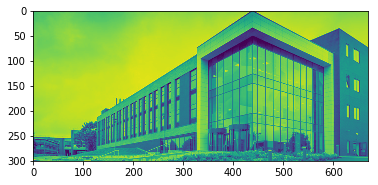

In [3]:
imgplot = plt.imshow(img)

In [4]:
img = cv2.GaussianBlur(img,(3,3),0)

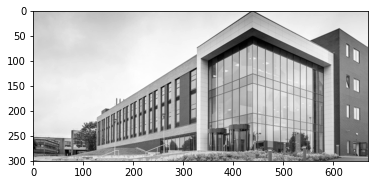

In [5]:
plt.imshow(img,cmap='gray')

In [6]:
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)

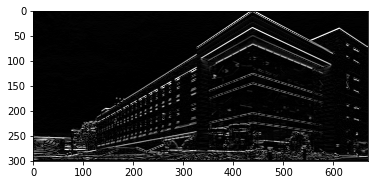

In [7]:
plt.imshow(np.abs(sobely),cmap='gray')

In [8]:
magn = np.hypot(sobelx,sobely)
direc = np.arctan2(sobely,sobelx)


In [9]:
rounded_direc = np.zeros((direc.shape),dtype=np.int32)
rounded_direc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [10]:
def rounded(angle):
    degree = np.rad2deg(angle)%180
    
    if ( ( 0 <= degree < 22.5) or ( 157.5 <= degree < 180)):
        angle = 0
    elif(22.5 <= degree < 67.5):
        angle = 45
    elif(67.5 <= degree < 112.5):
        angle = 90
    else :
        angle = 135
        
    return angle
    

In [11]:
for i in range(direc.shape[0]) :
        for j in range(direc.shape[1]) :
            rounded_direc[i][j] = rounded(direc[i,j])

In [12]:
rounded_direc

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ..., 90, 90, 90],
       [ 0,  0,  0, ..., 90, 90, 90],
       ..., 
       [90, 45, 90, ..., 90, 90, 90],
       [90, 45, 45, ...,  0, 45, 90],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

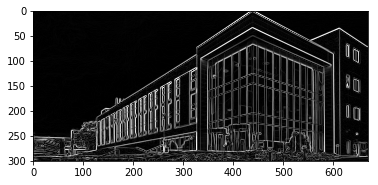

In [13]:
plt.imshow(magn,cmap='gray')

In [14]:
def non_max_suppression(magn,direc):
    M, N = magn.shape
    non_max = np.zeros((M,N), dtype = np.uint8)
    for i in range(M):
        for j in range(N):
            if(direc[i][j] == 0) :
                if((j!= 0 and j!= N-1) and (magn[i, j] >= magn[i, j - 1]) and (magn[i, j] >= magn[i, j + 1])):
                    non_max[i,j] = magn[i,j]
                    
            elif(direc[i][j] == 90) :
                if ((i!=0 and i!= M-1) and (magn[i, j] >= magn[i - 1, j]) and (magn[i, j] >= magn[i + 1, j])):
                    non_max[i,j] = magn[i,j]
            
            elif(direc[i][j] == 135) :
                if ((i!=0 and i!=M-1 and j!=0 and j!= N-1 ) and (magn[i, j] >= magn[i - 1, j + 1]) and (magn[i, j] >= magn[i + 1, j - 1])):
                    non_max[i,j] = magn[i,j]
            
            elif(direc[i][j] == 45) :
                if ((i!=0 and i!=M-1 and j!=0 and j!= N-1 ) and magn[i, j] >= magn[i - 1, j - 1]) and (magn[i, j] >= magn[i + 1, j + 1]):
                    non_max[i,j] = magn[i,j]
    
    return non_max

In [15]:
non_max = non_max_suppression(magn,rounded_direc)

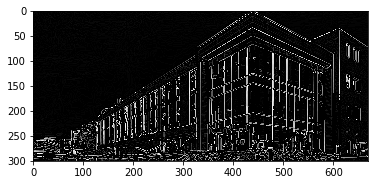

In [16]:
plt.imshow(non_max,cmap='gray')

In [17]:
non_max

array([[  0,   0,   8, ...,   0,   0,   0],
       [  0,   0,   8, ...,   4,   4,   4],
       [  0,   0,   7, ...,   4,   4,   4],
       ..., 
       [  0,   0,   0, ...,   0,   0,   0],
       [138, 214,  51, ...,   8,   0,   0],
       [  0,   0, 200, ...,  10,   0,   0]], dtype=uint8)

In [23]:
def hystersis_thresholding (img, low, high):
    low = np.clip(low, a_min=None, a_max=high)  # ensure low always below high
    mask_low = img > low
    mask_high = img > high
    # print(mask_high*1)
    # Connected components of mask_low
    labels_low, num_labels = ndimage.label(mask_low)

    # Check which connected components contain pixels from mask_high
    sums = ndimage.sum(mask_high, labels_low, np.arange(num_labels + 1))
    connected_to_high = sums > 0
    thresholded = connected_to_high[labels_low]
    return thresholded


In [24]:
thresh = hystersis_thresholding(non_max,50,100)

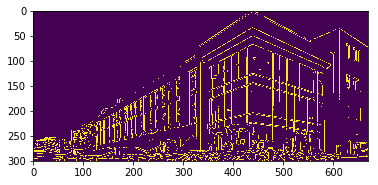

In [26]:
plt.imshow(thresh)

In [33]:
def color_edges(thresh, magn, direc) :
    M,N = thresh.shape
    hsv = np.zeros((M,N,3), dtype = np.uint8) 
    max_magn = np.max(magn)
    min_magn = np.min(direc)
    for i in range(M) :
        for j in range (N) :
            if(thresh[i][j]) :
                v = int(255*((magn[i][j] - min_magn)/(max_magn - min_magn)))
                if(direc[i][j] == 0) :
                    hsv[i][j] = [0,255,v]
                elif(direc[i][j] == 45) :
                     hsv[i][j] = [45,255,v]
                elif(direc[i][j] == 90) :
                     hsv[i][j] = [90,255,v]
                else :
                     hsv[i][j] = [135,255,v]
                        
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

In [36]:
hsv_image = color_edges(thresh, magn, rounded_direc)

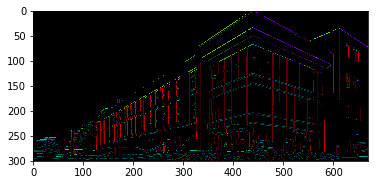

In [37]:
plt.imshow(hsv_image,cmap='gray')